In [28]:
from astropy.table import Table

import numpy as np

import sys
sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/')
from dark_matter_mass_v1 import rot_fit_BB
from DRP_vel_map_functions import mass_newton

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
H_0 = 100      # Hubble's Constant in units of h km/s/Mpc
c = 299792.458 # Speed of light in units of km/s

# Data

In [44]:
data_filename = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_SK_v6.txt'

data = Table.read(data_filename, format='ascii.commented_header')

In [45]:
################################################################################
# Calculate the velocity at R90, Rmax
#-------------------------------------------------------------------------------
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
dist_to_galaxy_Mpc = c*data['NSA_redshift']/H_0
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

data['R90_kpc'] = dist_to_galaxy_kpc*np.tan(data['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
data['R50_kpc'] = dist_to_galaxy_kpc*np.tan(data['NSA_elpetro_th50']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

data['V90_kms'] = rot_fit_BB(data['R90_kpc'], 
                             [data['Vmax_map'], 
                              data['Rturn_map'], 
                              data['alpha_map']])

data['V50_kms'] = rot_fit_BB(data['R50_kpc'], 
                             [data['Vmax_map'], 
                              data['Rturn_map'], 
                              data['alpha_map']])
################################################################################

/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: overflow encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


In [46]:
data['M90_Mdisk_ratio'] = 10**(data['M90_map'] - data['M90_disk_map'])

data['M50_map'],_ = mass_newton(data['V50_kms'], np.zeros(len(data)), data['R50_kpc'])

/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/DRP_vel_map_functions.py:1600: RuntimeWarning: invalid value encountered in true_divide
  m_err = 2*m*(v_err/v)


In [47]:
bad_boolean = np.logical_or.reduce([np.isnan(data['M90_map']), 
                                    np.isnan(data['M90_disk_map']), 
                                    data['alpha_map'] > 99, 
                                    data['ba_map'] > 0.998, 
                                    data['V90_kms']/data['Vmax_map'] < 0.9, 
                                    (data['Tidal'] & (data['DL_merge'] > 0.97)), 
                                    data['map_frac_unmasked'] < 0.05, 
                                    (data['map_frac_unmasked'] > 0.13) & (data['DRP_map_smoothness'] > 1.96), 
                                    (data['map_frac_unmasked'] > 0.07) & (data['DRP_map_smoothness'] > 2.9), 
                                    (data['map_frac_unmasked'] > -0.0638*data['DRP_map_smoothness'] + 0.255) & (data['DRP_map_smoothness'] > 1.96), 
                                    data['M90_Mdisk_ratio'] > 1050])

good_galaxies = data[~bad_boolean]

# Mass comparison

## $M (R_{90})$ v. $M_{dyn} (R_{90})$ from $S_K^2$

Might not match, since $\eta = 1.8$ is scaled for $M_{dyn} (R_{50})$.

<IPython.core.display.Javascript object>


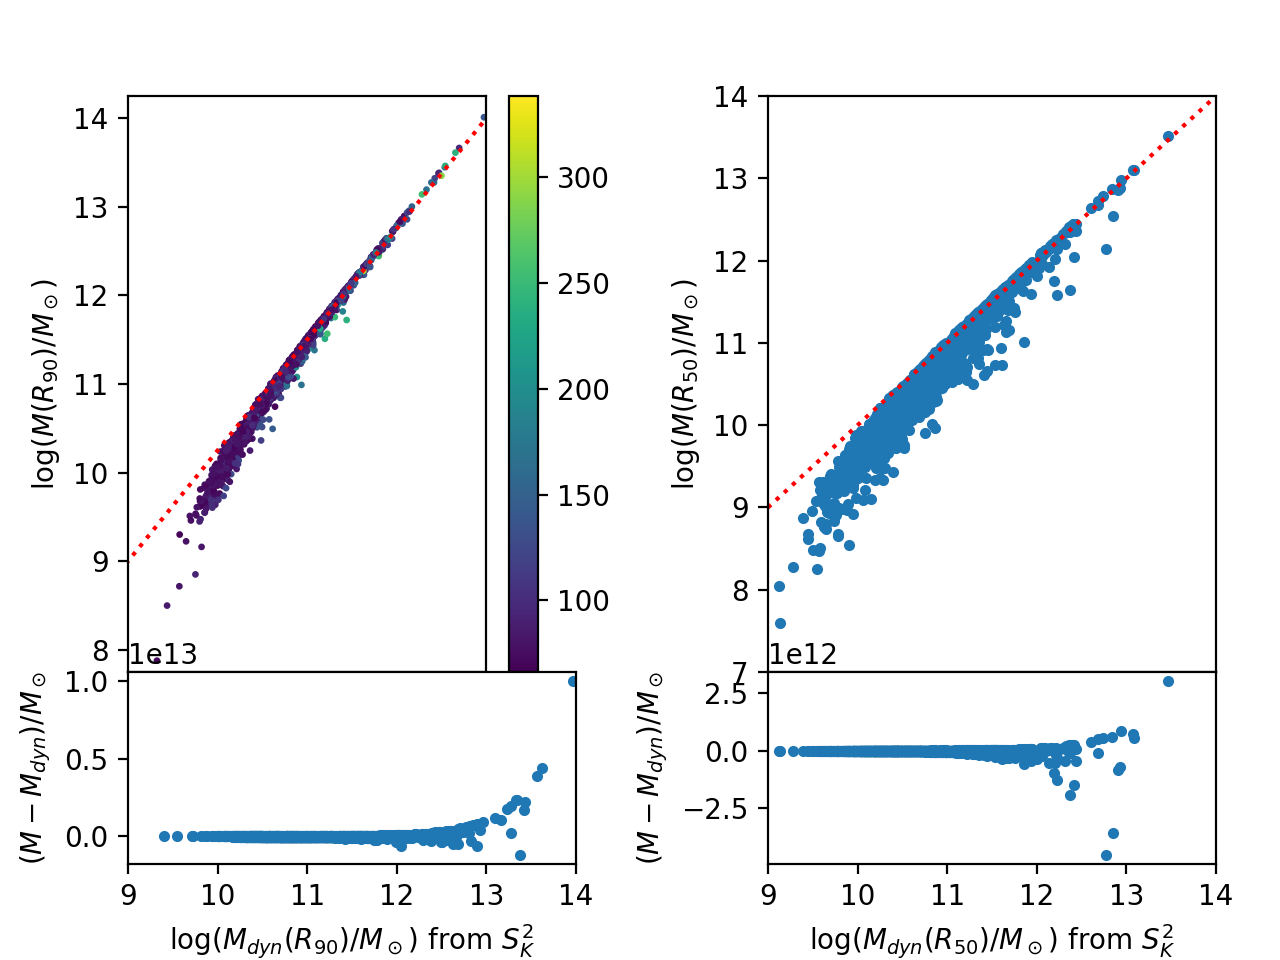

In [55]:
fig = plt.figure(tight_layout=True)

################################################################################
plt1 = fig.add_axes((0.1,0.3,0.35,0.6))

plt.scatter(np.log10(good_galaxies['Mdyn90_SK']), 
            good_galaxies['M90_map'], 
            c=good_galaxies['sigma'], s=2)

plt.colorbar()

plt.plot([8,14], [8,14], 'r:')

plt.xlim(9,14)
plt.ylim(7.75, 14.25)

plt1.axes.get_xaxis().set_visible(False)

plt.ylabel('log($M (R_{90}) / M_\odot$)')
################################################################################


################################################################################
# Residual
#-------------------------------------------------------------------------------
rsd1 = fig.add_axes((0.1, 0.1, 0.35, 0.2))

plt.plot(np.log10(good_galaxies['Mdyn90_SK']), 
         10**good_galaxies['M90_map'] - good_galaxies['Mdyn90_SK'], 
         '.')

plt.xlim(9,14)

plt.xlabel('log($M_{dyn} (R_{90}) / M_\odot$) from $S_K^2$')
plt.ylabel('($M - M_{dyn})/M_\odot$')
################################################################################


################################################################################
plt2 = fig.add_axes((0.6, 0.3, 0.35, 0.6))

plt.plot(np.log10(good_galaxies['Mdyn50_SK']), 
         np.log10(good_galaxies['M50_map']), 
         '.')

plt.plot([8,14], [8,14], 'r:')

plt.xlim(9,14)
plt.ylim(7, 14)

plt2.axes.get_xaxis().set_visible(False)

plt.ylabel('log($M (R_{50}) / M_\odot$)')
################################################################################


################################################################################
# Residual
#-------------------------------------------------------------------------------
rsd1 = fig.add_axes((0.6, 0.1, 0.35, 0.2))

plt.plot(np.log10(good_galaxies['Mdyn50_SK']), 
         good_galaxies['M50_map'] - good_galaxies['Mdyn50_SK'], 
         '.')

plt.xlim(9,14)

plt.xlabel('log($M_{dyn} (R_{50}) / M_\odot$) from $S_K^2$')
plt.ylabel('($M - M_{dyn})/M_\odot$');
################################################################################

## $M (R_{90})$ v. $M_{dyn} (R_{50})$ from $S_K^2$

Not really expected to match, since they are evaluated at different radii.

<IPython.core.display.Javascript object>


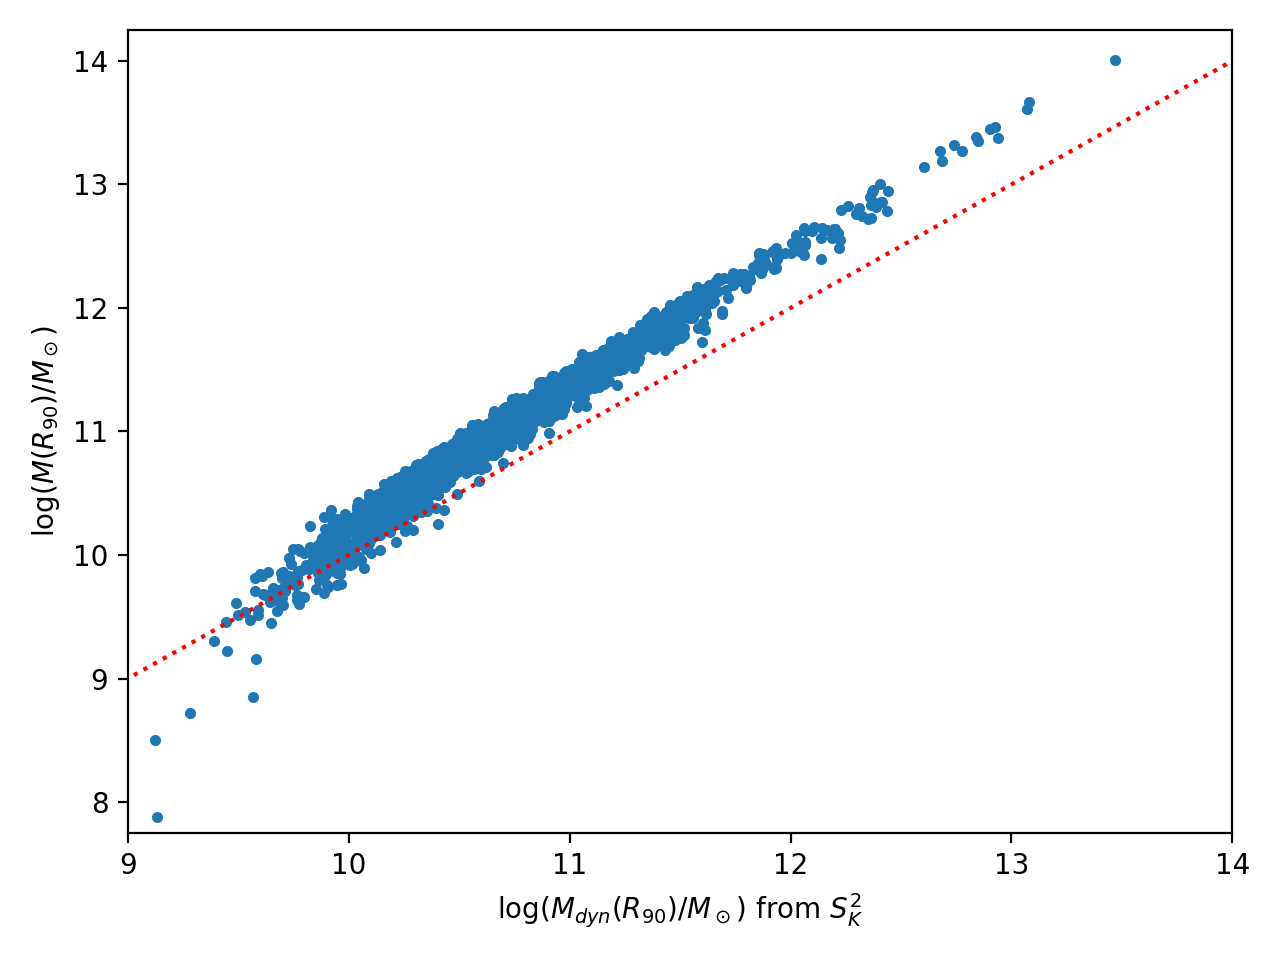

In [49]:
plt.figure(tight_layout=True)

plt.plot(np.log10(good_galaxies['Mdyn50_SK']), good_galaxies['M90_map'], '.')

plt.plot([8,14], [8,14], 'r:')

plt.xlim(9,14)
plt.ylim(7.75, 14.25)

plt.xlabel('log($M_{dyn} (R_{90}) / M_\odot$) from $S_K^2$')
plt.ylabel('log($M (R_{90}) / M_\odot$)');

# Mass v. $S_K$

## $M_d (R_{90})$ v. $S_K$

A psuedo-bTFR

In [50]:
logM = np.linspace(7, 14, 10)

AO18 = -0.92 + 0.29*logM
AO20 = -1.56 + 0.34*logM

<IPython.core.display.Javascript object>


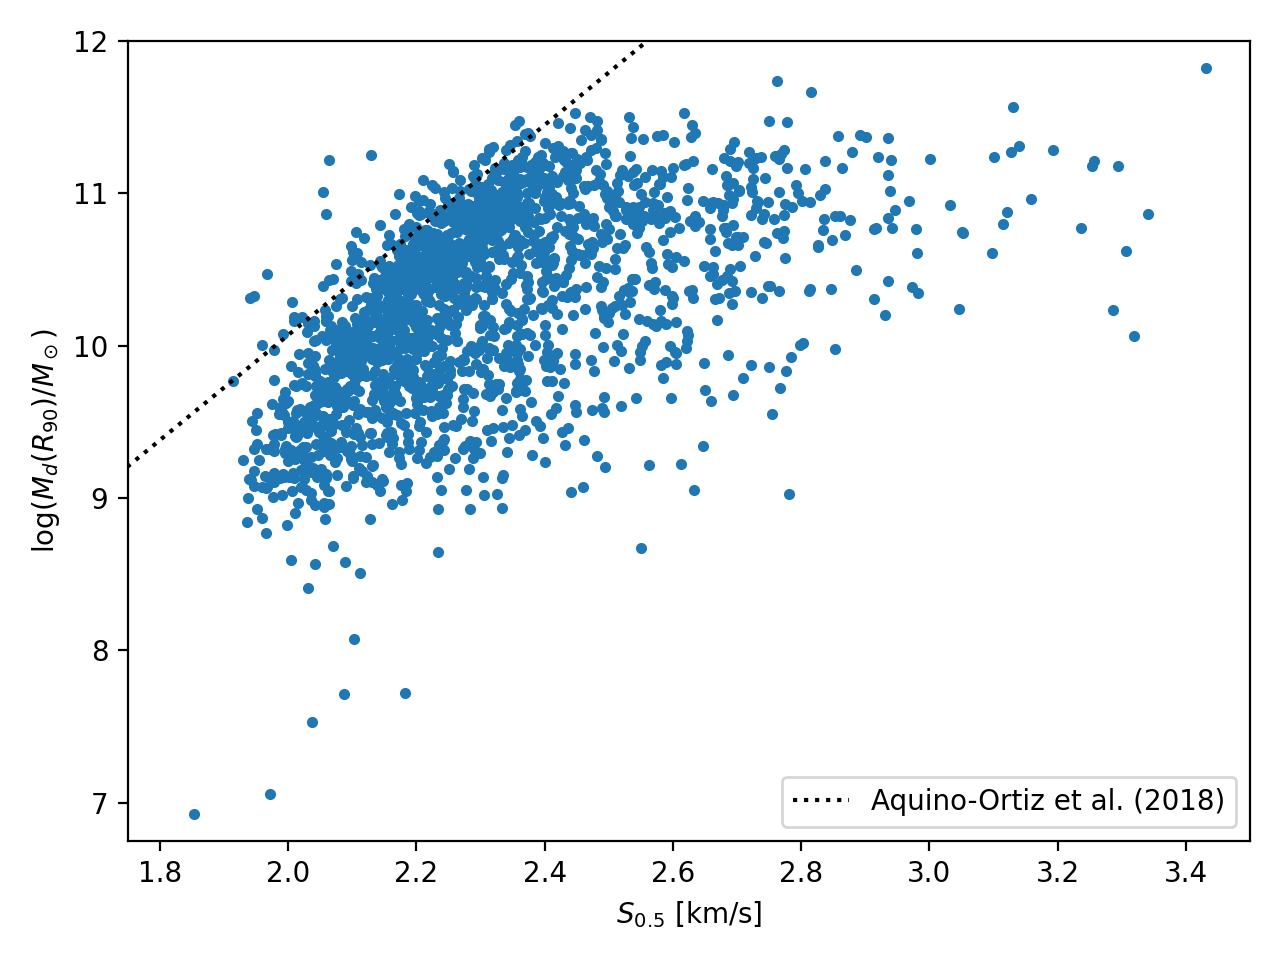

In [51]:
plt.figure(tight_layout=True)

plt.plot(np.log10(np.sqrt(good_galaxies['SK'])), good_galaxies['M90_disk_map'], '.')

plt.plot(AO18, logM, 'k:', label='Aquino-Ortiz et al. (2018)')

plt.xlim(1.75, 3.5)
plt.ylim(6.75, 12)

plt.xlabel('$S_{0.5}$ [km/s]')
plt.ylabel('log($M_d (R_{90}) / M_\odot$)')

plt.legend();

I actually think that this matches decently well.  I would argue that they should not be fitting a linear line to this, as, even as their Fig. 4 shows, the data drops very quickly.

## $M (R_{90})$ v. $S_K$

<IPython.core.display.Javascript object>


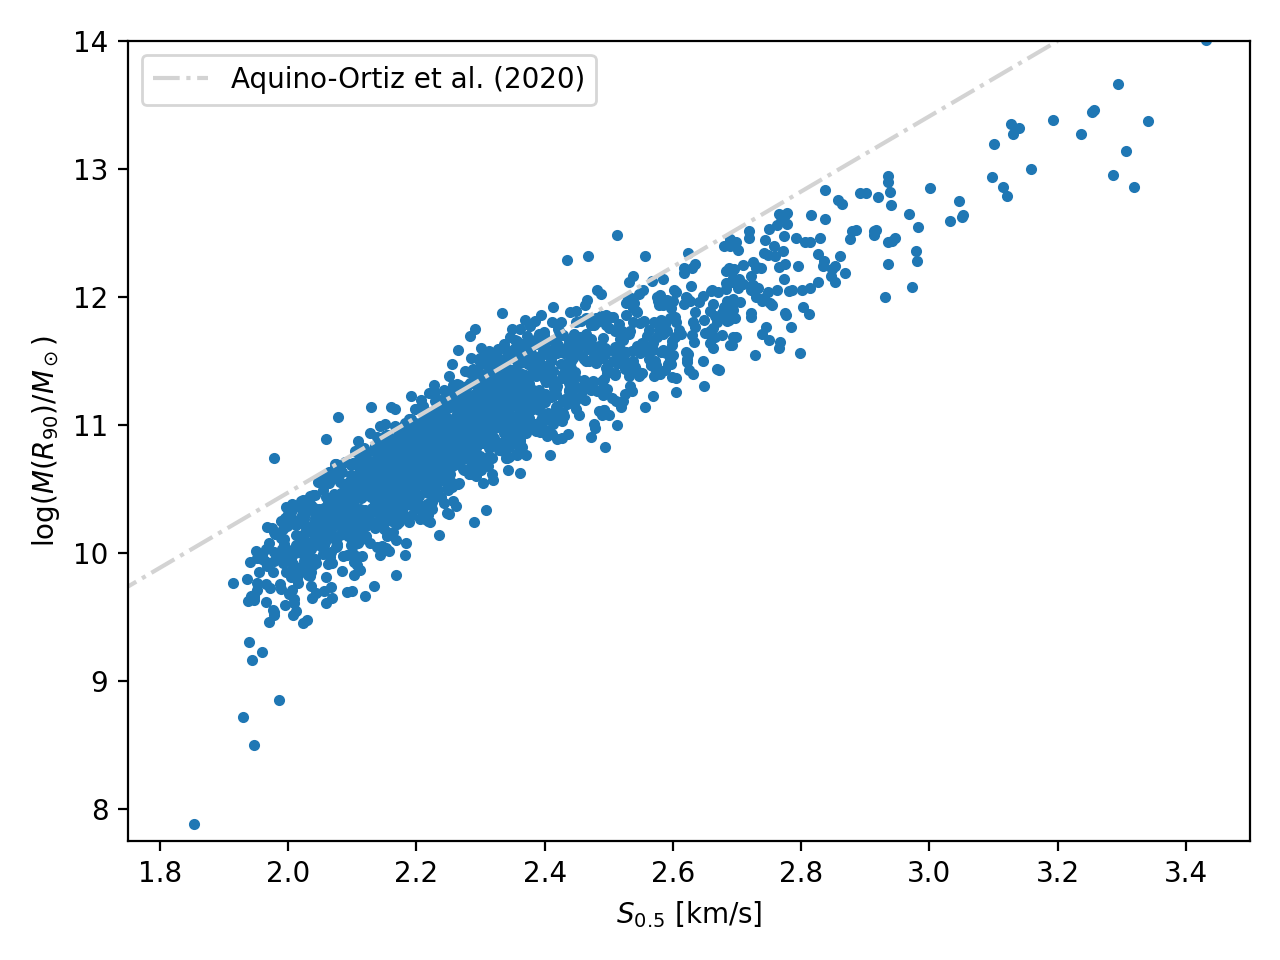

In [52]:
plt.figure(tight_layout=True)

plt.plot(np.log10(np.sqrt(good_galaxies['SK'])), good_galaxies['M90_map'], '.')

plt.plot(AO20, logM, '-.', c='lightgray', label='Aquino-Ortiz et al. (2020)')

plt.xlim(1.75, 3.5)
plt.ylim(7.75, 14)

plt.xlabel('$S_{0.5}$ [km/s]')
plt.ylabel('log($M (R_{90}) / M_\odot$)')

plt.legend();